In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.2
pandas 0.23.4
sklearn 0.19.1
scipy 0.19.1
lightgbm 2.1.1
seaborn 0.8.0


# load the data

In [3]:
import os
import tarfile
from six.moves import urllib
PATH = os.path.join("journey", "data")
def load_data(file):
    csv_path = os.path.join(PATH,file)
    return pd.read_csv(csv_path)

In [4]:
sales = load_data('sales_train.csv')
shops = load_data('shops.csv')
items = load_data('items.csv')
item_cats = load_data('item_categories.csv')
test = load_data('test.csv')

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
print("sales----------------------------")
sales.info()
print("shops----------------------------")
shops.info()
print("items----------------------------")
items.info()
print("item_cats----------------------------")
item_cats.info()
print("test----------------------------")
test.info()

sales----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
shops----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB
items----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
item_cats----------------------------
<class 'pandas.core.frame.DataFrame'

# a summary of the numerical attributes


In [10]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


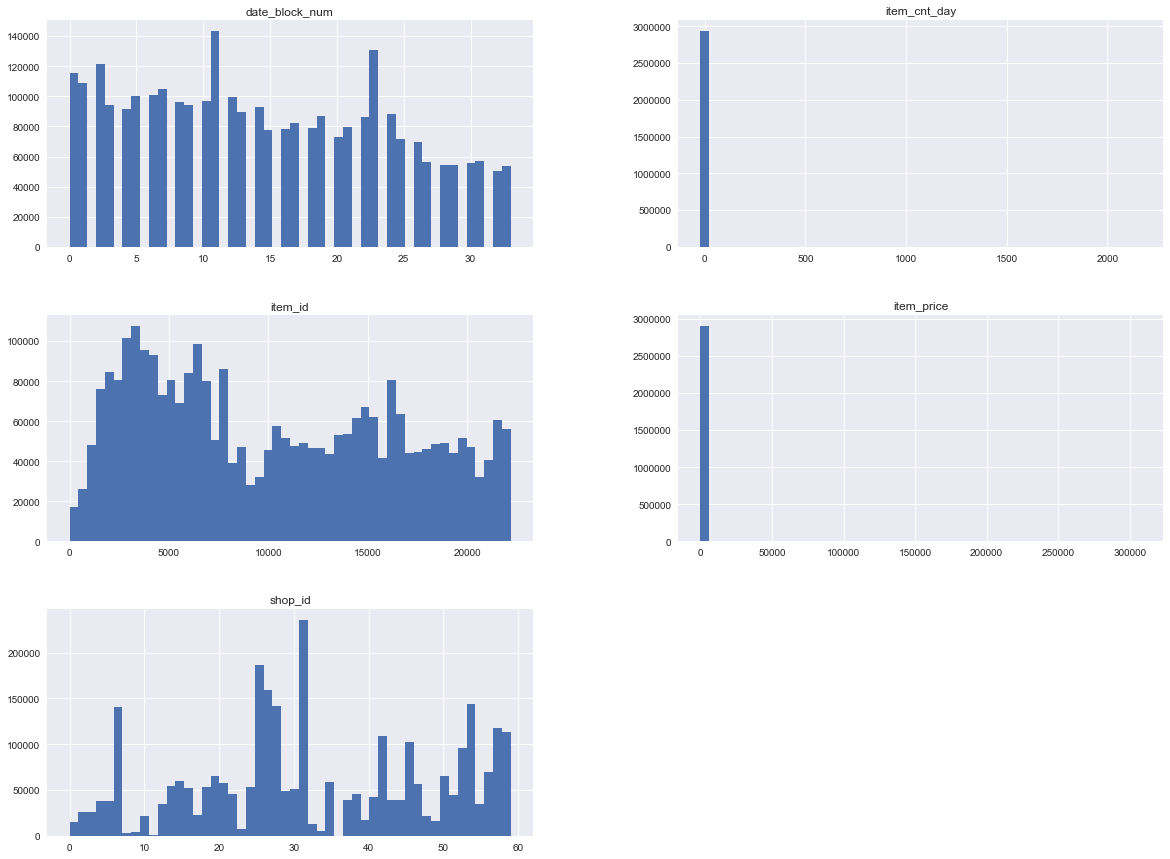

In [11]:
sales.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

### it looks like we have outliers on item_cnt_day and item_price

# item_cnt_day (target)

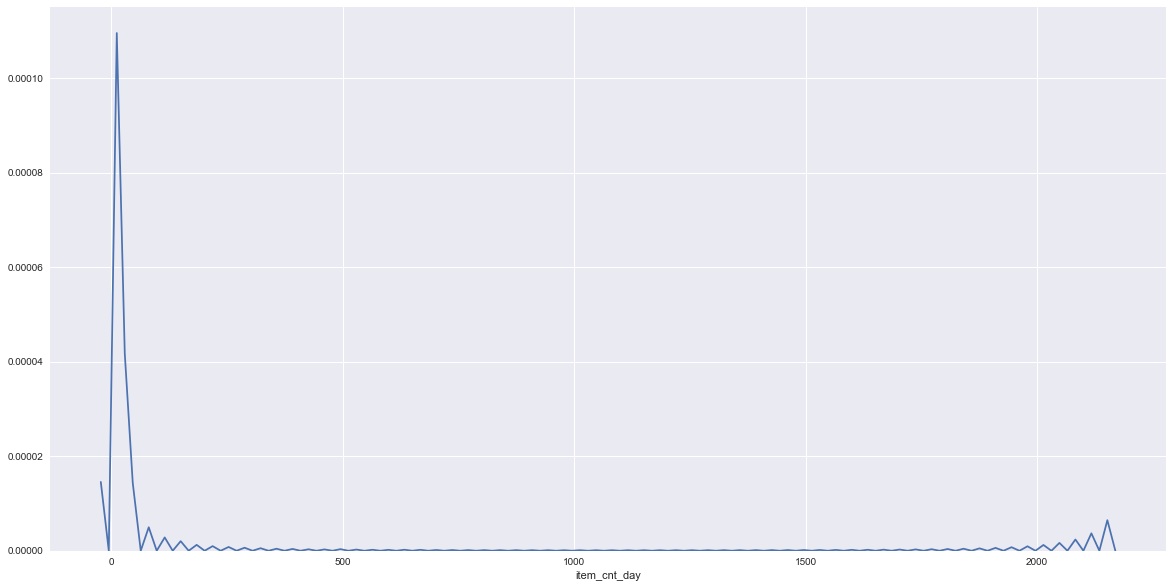

In [12]:
sns.distplot(sales.item_cnt_day,hist=False)
plt.show()

In [13]:
x,y=np.percentile(sales['item_cnt_day'].astype('int'),q=[1,99])
cut=np.clip(sales['item_cnt_day'],x,y)
cut.max()

5.0

1.0    2636728
2.0     194201
3.0      47350
5.0      37885
4.0      19685
Name: item_cnt_day, dtype: int64


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


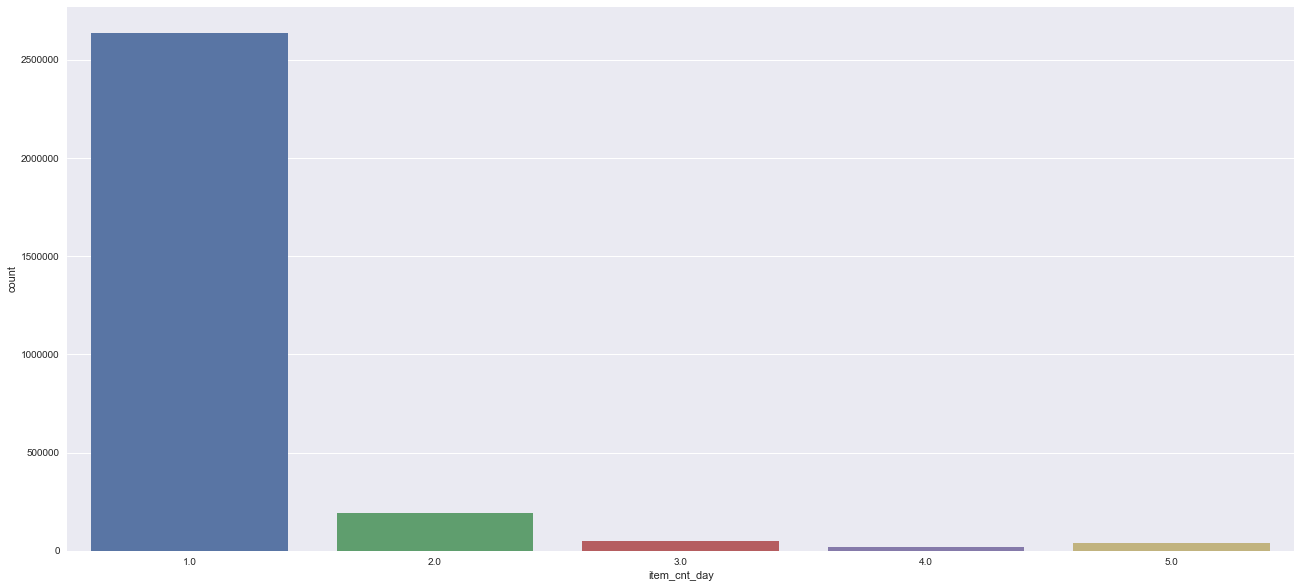

In [14]:
# item_cnt_day %99instances
print(cut.value_counts())
plt.figure(figsize=(22,10))
sns.countplot(cut)
plt.show()

##### Outliers!!! There are strange item_cnt_day values

C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


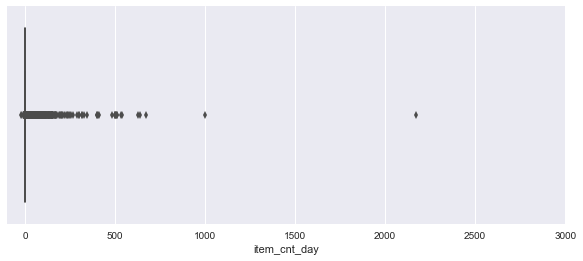

In [18]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

In [66]:
to_drop=sales[sales['item_cnt_day']>5]
to_drop.item_cnt_day.unique()

array([  13.,    7.,    6.,    8.,   10.,   11.,   30.,   22.,   14.,
         15.,    9.,   12.,   17.,   19.,   20.,   16.,   64.,   18.,
         29.,   26.,   39.,   21.,   27.,   53.,   25.,   23.,   24.,
         40.,   28.,   31.,   36.,   32.,   35.,   41.,   88.,   44.,
         52.,   56.,   38.,   34.,   57.,   69.,   37.,   47.,   50.,
         48.,   33.,   61.,   80.,   42.,   82.,  200.,  100.,   76.,
         77.,  107.,   46.,   49.,   70.,   55.,   60.,   45.,   71.,
         65.,  150.,   85.,   89.,   43.,   58.,  217.,  104.,   84.,
        168.,   92.,  156.,   68.,   62.,  264.,  110.,   83.,  133.,
         51.,  148.,   54.,   67.,  106.,  109.,  102.,   90.,  288.,
        171.,  131.,   87.,   78.,  151.,   59.,  113.,  118.,  127.,
         97.,  135.,  103.,  111.,   96.,  242.,  105.,   72.,  126.,
         73.,  101.,   91.,   63.,  194.,  255.,   98.,   81.,   75.,
         74.,  121.,  405.,   99.,  300.,  401.,  502.,  138.,  134.,
         66.,  240.,

In [67]:
to_drop=sales[sales['item_cnt_day']>200]
to_drop.item_cnt_day.unique()

array([ 217.,  264.,  288.,  242.,  255.,  405.,  300.,  401.,  502.,
        240.,  501.,  251.,  512.,  508.,  412.,  313.,  500.,  205.,
       1000.,  222.,  325.,  207.,  231.,  299.,  624.,  480.,  343.,
        539.,  230.,  533.,  637.,  669.,  504., 2169.])

20949    11
8057      3
11373     3
3732      3
3731      3
9249      2
9248      2
5917      2
19437     2
19445     1
11370     1
11369     1
10210     1
10209     1
9242      1
3730      1
Name: item_id, dtype: int64


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


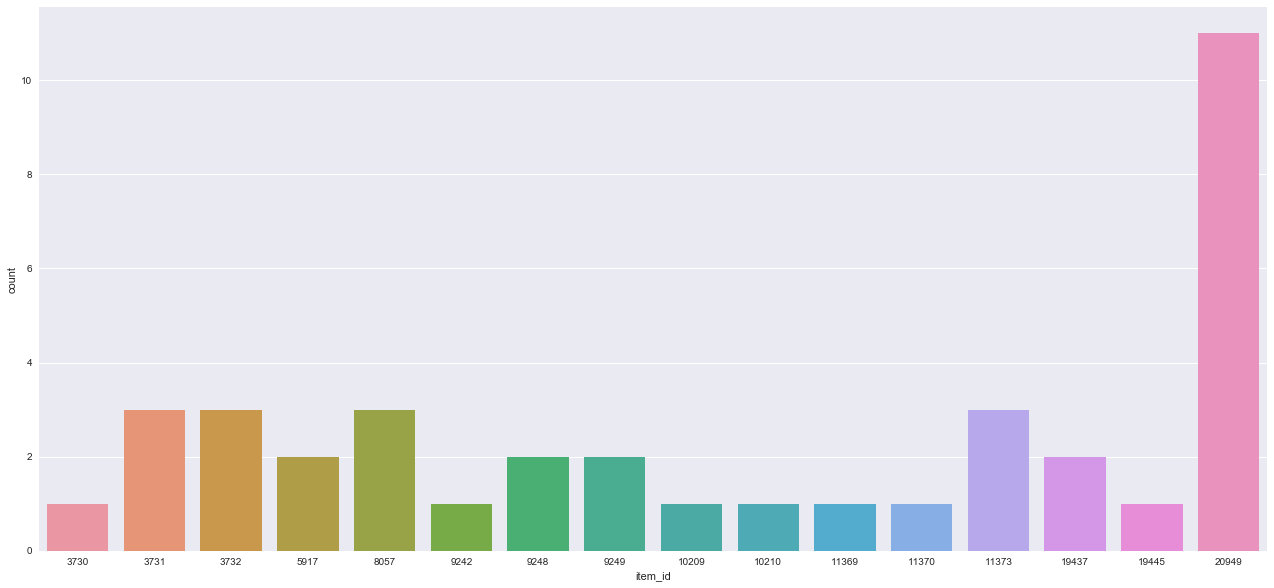

In [68]:
print(to_drop.item_id.value_counts())
plt.figure(figsize=(22,10))
sns.countplot(to_drop.item_id)
plt.show()

### step1 I guess we need to drop those high itel_cnt_day instance that appearnce once in some items 

In [69]:
drop=to_drop.item_id.value_counts()[to_drop.item_id.value_counts()<11].index

In [70]:
cnt_day_to_drop=to_drop[to_drop.item_id.isin(drop)].item_cnt_day

In [71]:
sales=sales[~sales.item_cnt_day.isin(cnt_day_to_drop)]#DROP THOSE ITEMS

## Investigate about item_id=20949 

In [72]:
item_inv=sales[sales['item_id']==20949]
item_inv.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,31338.000000,31338.000000,31338.0,31338.000000,31338.000000
mean,17.683037,31.632331,20949.0,4.914858,5.971153
std,8.255885,16.907735,0.0,0.398053,11.310727
min,3.000000,2.000000,20949.0,1.830000,-16.000000
25%,11.000000,18.000000,20949.0,5.000000,2.000000
50%,17.000000,30.000000,20949.0,5.000000,3.000000
75%,24.000000,46.000000,20949.0,5.000000,7.000000
max,33.000000,59.000000,20949.0,5.000000,1000.000000


 1.0       6605
 2.0       5483
 3.0       4156
 4.0       3125
 5.0       2325
 6.0       1682
 7.0       1246
 8.0        927
 9.0        791
 10.0       592
 11.0       505
 13.0       429
 12.0       423
 14.0       298
 15.0       273
 16.0       232
 17.0       211
 19.0       190
 18.0       179
 20.0       159
 21.0       156
 22.0       120
 24.0        98
 23.0        96
 25.0        91
 26.0        79
 28.0        73
 27.0        73
 30.0        62
 32.0        55
 29.0        53
 31.0        51
 33.0        43
 37.0        35
 34.0        34
 36.0        33
 41.0        29
 35.0        28
 39.0        27
 38.0        21
 46.0        19
 40.0        18
 42.0        16
 44.0        15
 49.0        12
 43.0        12
 45.0        11
 50.0        10
 55.0        10
 48.0         9
 47.0         9
 54.0         6
 52.0         6
 59.0         6
 60.0         5
 64.0         5
 53.0         5
 62.0         5
 65.0         4
 51.0         4
 80.0         4
 57.0         4
 67.0   

C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


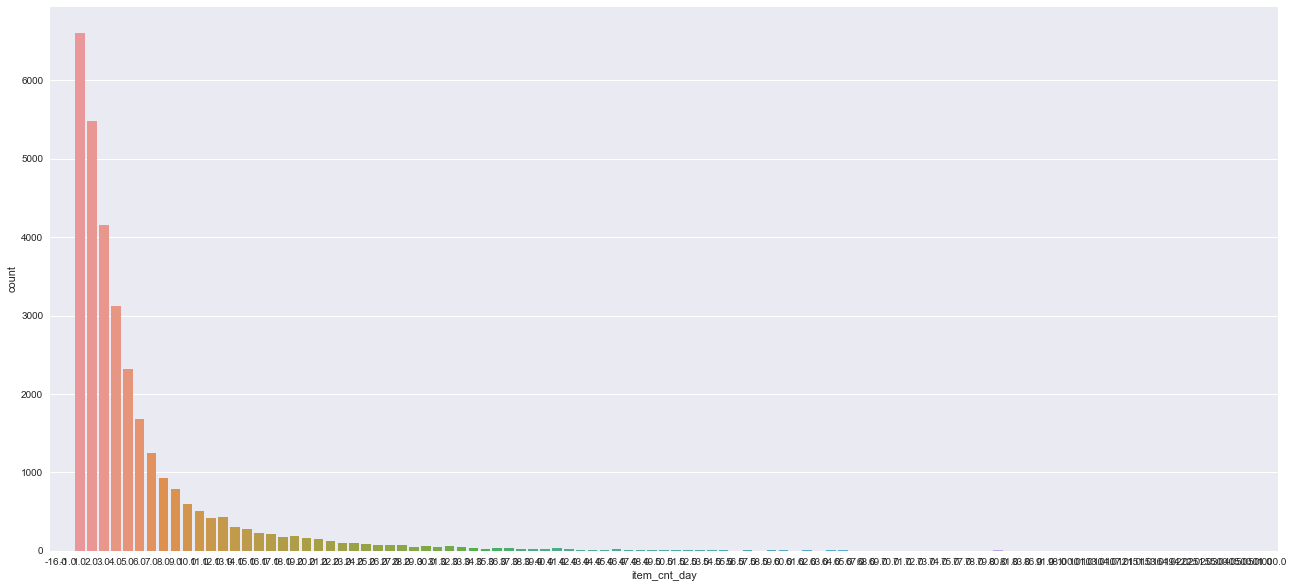

In [73]:
print(item_inv.item_cnt_day.value_counts())
plt.figure(figsize=(22,10))
sns.countplot(item_inv.item_cnt_day)
plt.show()

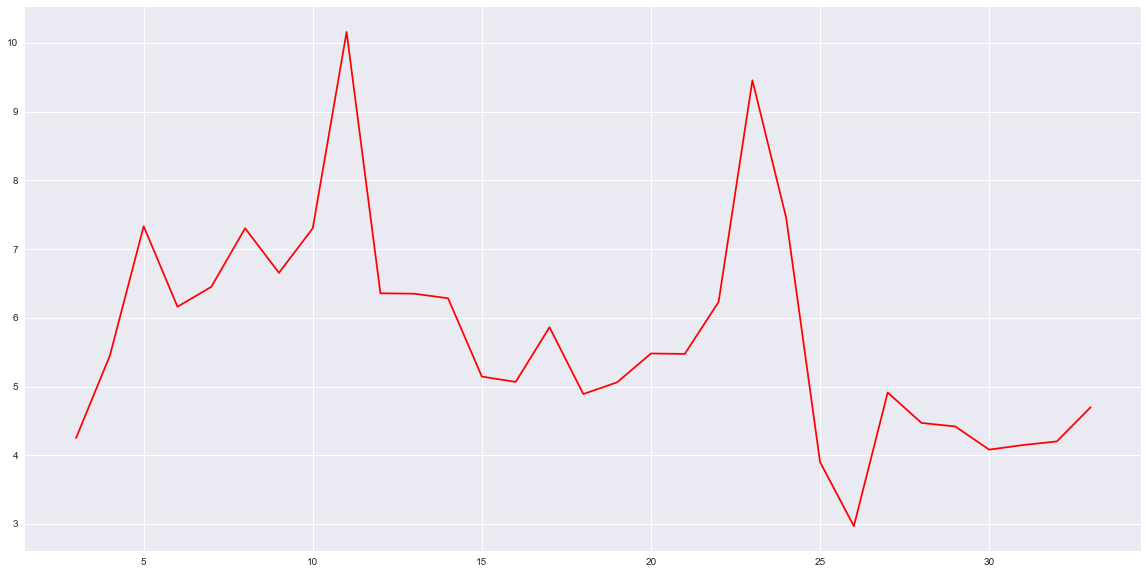

In [74]:
df=item_inv.groupby(['date_block_num'])['item_cnt_day'].mean()
plt.plot(df.index,df.values,c='r')
plt.show()

* try to eliminate hight cnt_day values

In [75]:
item_inv_1=item_inv[item_inv.item_cnt_day<200]

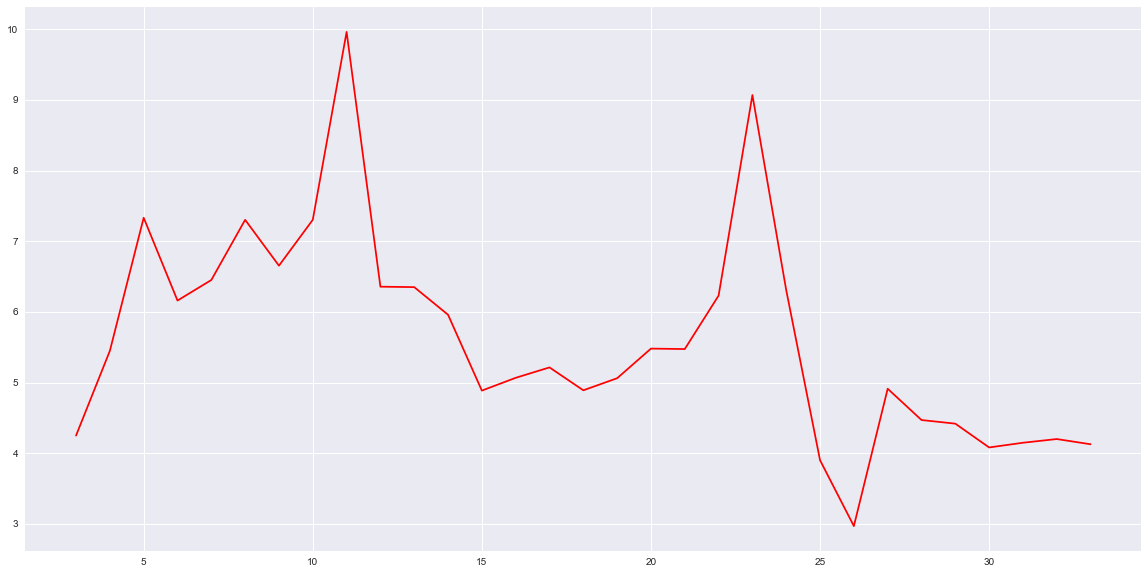

In [76]:
df=item_inv_1.groupby(['date_block_num'])['item_cnt_day'].mean()
plt.plot(df.index,df.values,c='r')
plt.show()

* we notice that most of those values have date_block=17 and 16

* lets try to increase threshold from 200 to 400

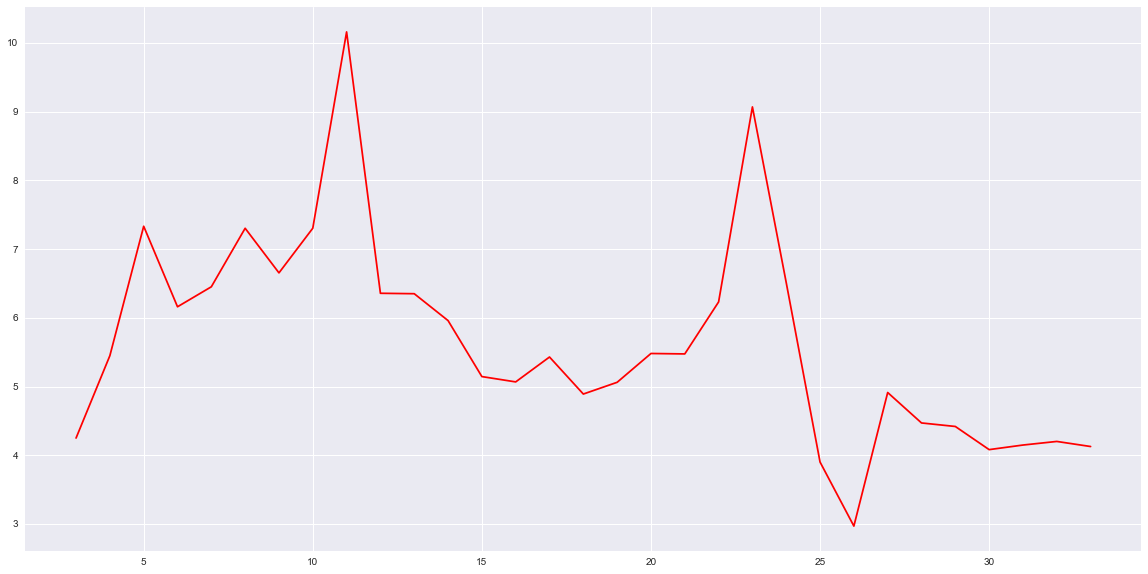

In [77]:
item_inv_1=item_inv[item_inv.item_cnt_day<400]
df=item_inv_1.groupby(['date_block_num'])['item_cnt_day'].mean()
plt.plot(df.index,df.values,c='r')
plt.show()

* now most of those values have date_block=17 and over all this figure is equivalent to the first figure but with less value on date_block=17 so its save to drop those higher value (threshold = 400) rather than other one (threshold = 200)

In [84]:
sales=sales[~((sales['item_id']==20949) & (sales.item_cnt_day>400))]#drop those items

#### now look at the distribution of item_cnt_day


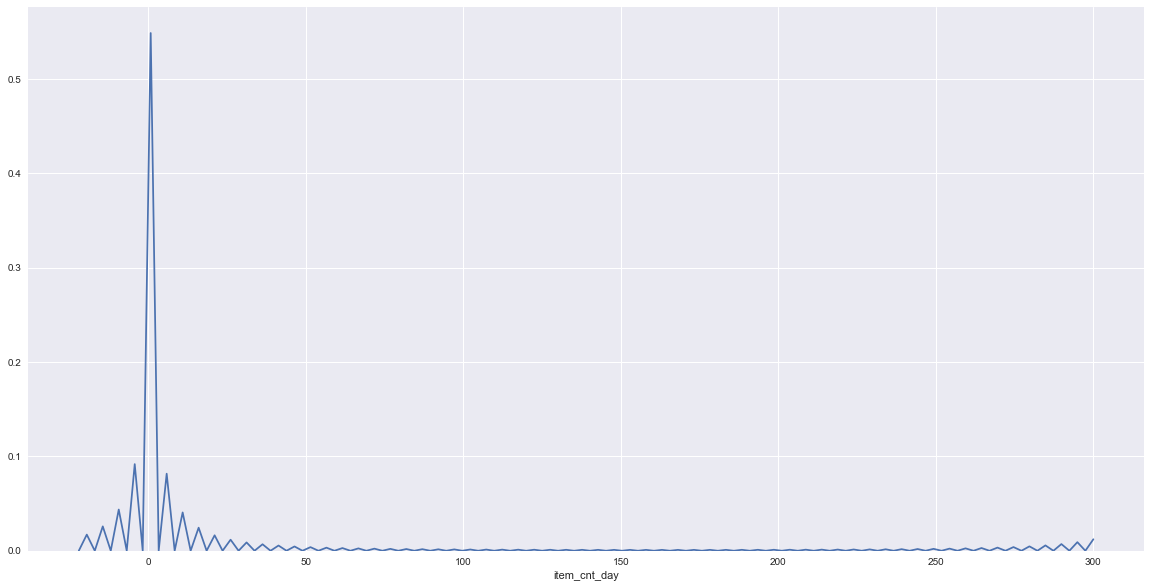

In [93]:
sns.distplot(sales.item_cnt_day,hist=False)
plt.show()

# item_price

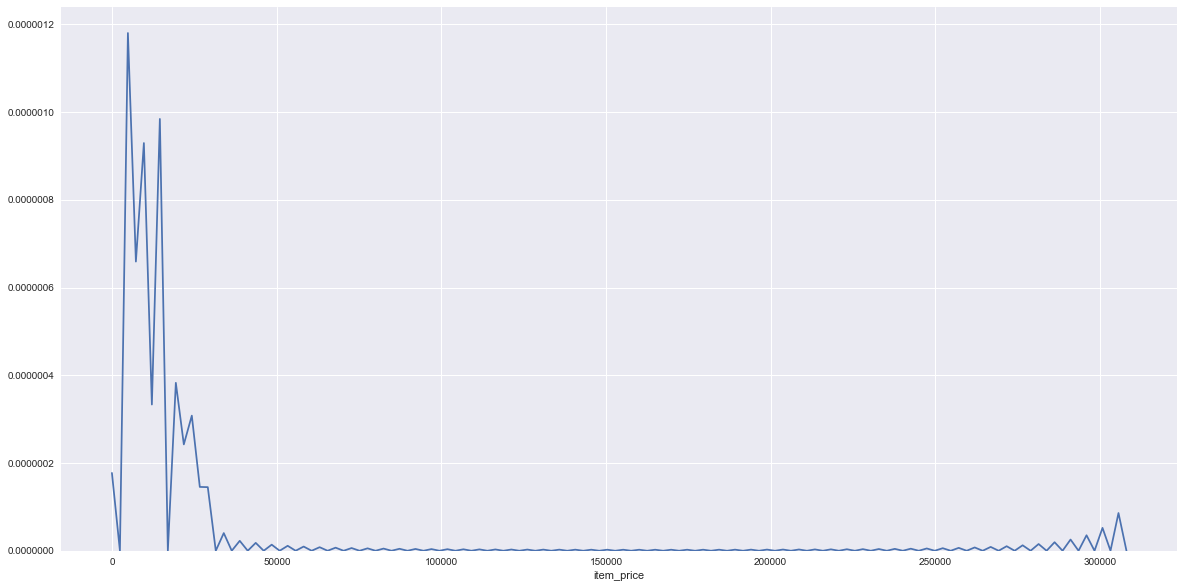

In [94]:
sns.distplot(sales.item_price,hist=False)
plt.show()

C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


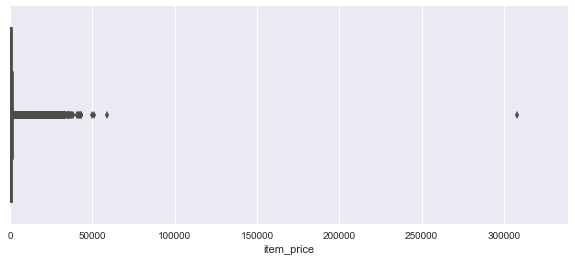

In [19]:
plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)

In [106]:
x,y=np.percentile(sales[sales.item_price >=6000]["item_price"].astype('float64'),q=[1,99])
cut=np.clip(sales[sales.item_price >=6000]["item_price"],x,y)
cut.max()

29990.0

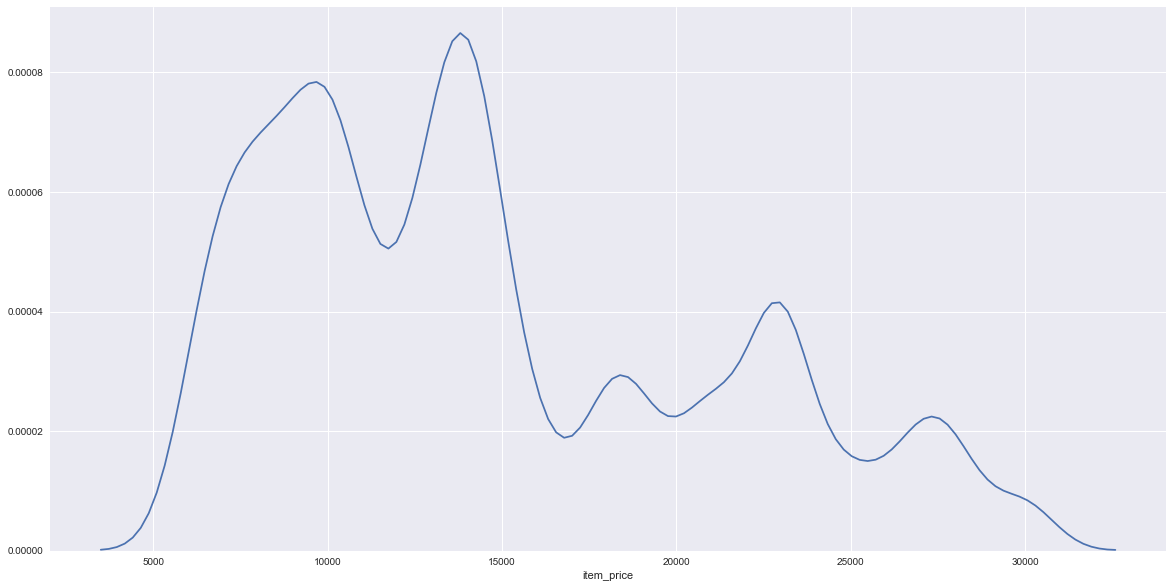

In [108]:
sns.distplot(cut,hist=False)
plt.show()

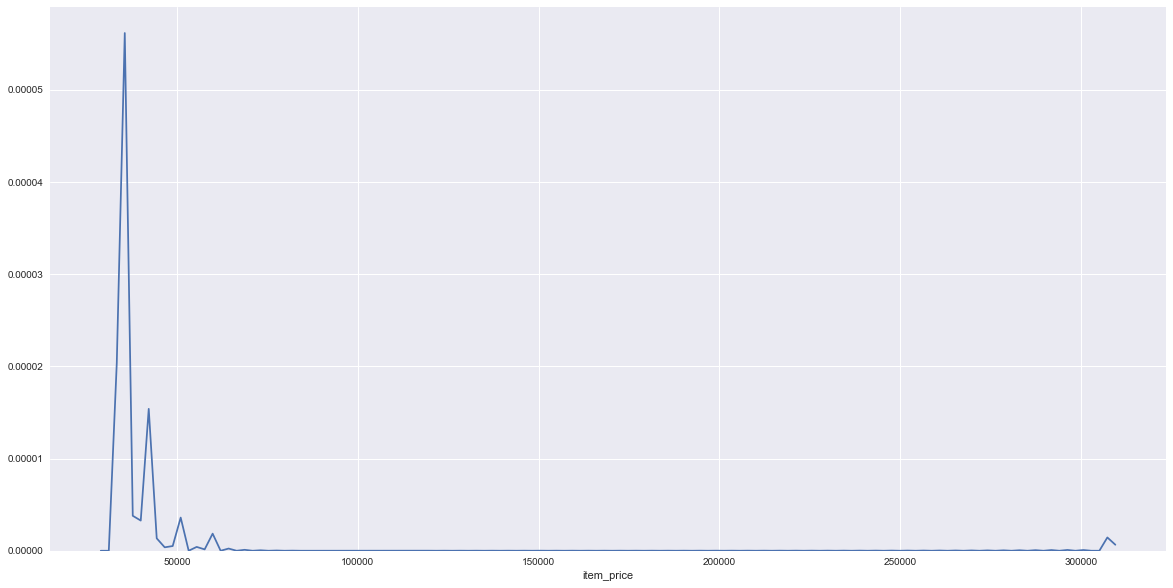

In [111]:
sns.distplot(sales[sales.item_price >=30000]["item_price"],hist=False)
plt.show()

In [125]:
for i in sales[sales.item_price >=30000].item_id.unique():
    number=len(sales[sales['item_id']==i])
    if number ==1:
        print(number-1,"items that shared the same id with the item_price=",sales[sales['item_id']==i].item_price.max())

0 items that shared the same id with the item_price= 42000.0
0 items that shared the same id with the item_price= 307980.0
0 items that shared the same id with the item_price= 50999.0
0 items that shared the same id with the item_price= 40900.0
0 items that shared the same id with the item_price= 49782.0


### let check if this itemes exist in test set

In [134]:
for outlier_id in sales[sales.item_price >=30000].item_id.unique():
    number=len(sales[sales['item_id']==outlier_id])
    if number ==1:    
        boolean=outlier_id in test.item_id
        if boolean ==True:
            print("item_id=",outlier_id,"and item_price=",sales[sales['item_id']==outlier_id].item_price.max(),"exist in the test set") 

item_id= 7238 and item_price= 42000.0 exist in the test set
item_id= 6066 and item_price= 307980.0 exist in the test set
item_id= 13199 and item_price= 50999.0 exist in the test set
item_id= 14173 and item_price= 40900.0 exist in the test set
item_id= 7241 and item_price= 49782.0 exist in the test set


In [136]:
for outlier_id in sales[sales.item_price >=30000].item_id.unique():
    number=len(sales[sales['item_id']==outlier_id])    
    boolean=outlier_id in test.item_id
    if boolean ==False:
        print("item_id=",outlier_id,"and item_price=",sales[sales['item_id']==outlier_id].item_price.max(),"exist in the test set") 

* let investigate about the instance with the higher item_price 307980.0

In [129]:
sales[sales.item_id ==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


* is it normale to have this instance even if it exist on the test set ???


### all of them are in the test set so we should keep them

### lets now check other items that exist multiple times on the train set with diff price!!


In [342]:
for i in df["index"]:
    outlier_id=sales[sales['item_price']==i]['item_id'].values[0]
    number=len(sales[sales['item_id']==outlier_id])
    if number >=2:
        print(number-1,"items that shared the same id with the item_price=",i)
    

94 items that shared the same id with the item_price= 35192.0
1 items that shared the same id with the item_price= 30705.0
94 items that shared the same id with the item_price= 32092.0
11 items that shared the same id with the item_price= 40991.0
94 items that shared the same id with the item_price= 34490.0
143 items that shared the same id with the item_price= 30991.0
11 items that shared the same id with the item_price= 35991.0
94 items that shared the same id with the item_price= 33990.0
16 items that shared the same id with the item_price= 31191.0
143 items that shared the same id with the item_price= 32382.0
94 items that shared the same id with the item_price= 32997.5
76 items that shared the same id with the item_price= 30789.5
70 items that shared the same id with the item_price= 31699.0
1 items that shared the same id with the item_price= 32437.0
70 items that shared the same id with the item_price= 31599.0
241 items that shared the same id with the item_price= 59200.0


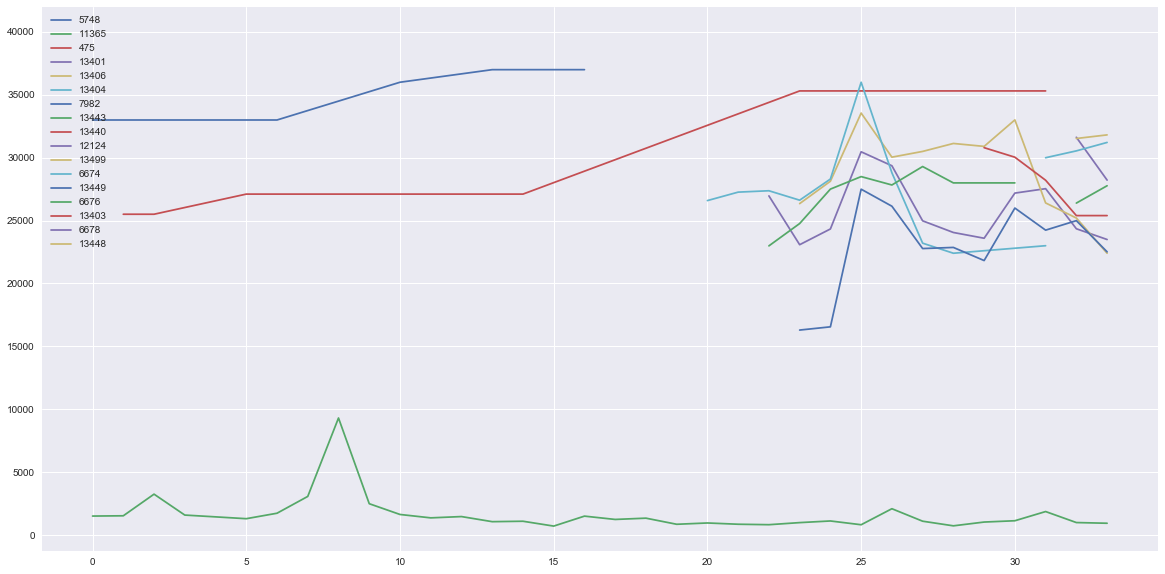

In [149]:
for outlier_id in sales[sales.item_price >=30000].item_id.unique():
    number=len(sales[sales['item_id']==outlier_id])
    if number >=5:    
        outlier_df=sales[sales['item_id']==outlier_id]
        df=outlier_df.groupby(['date_block_num'])['item_price'].mean()
        plt.plot(df.index,df.values,label=outlier_id)
        plt.legend(loc='upper left')
plt.show()

In [150]:
outlier_df=sales[sales['item_id']==11365]
outlier_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58283,09.01.2013,0,12,11365,1148.000000,5.0
58284,10.01.2013,0,12,11365,2235.000000,2.0
58285,14.01.2013,0,12,11365,1753.333333,3.0
58286,15.01.2013,0,12,11365,1435.000000,2.0
58287,16.01.2013,0,12,11365,1930.000000,1.0


In [151]:
outlier_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,242.000000,242.0,242.0,242.000000,242.000000
mean,13.904959,12.0,11365.0,1887.565416,4.161157
std,10.380882,0.0,0.0,4119.496611,8.232794
min,0.000000,12.0,11365.0,124.000000,1.000000
25%,5.000000,12.0,11365.0,618.977273,1.000000
50%,12.000000,12.0,11365.0,1203.750000,2.000000
75%,23.000000,12.0,11365.0,1937.500000,4.000000
max,33.000000,12.0,11365.0,59200.000000,103.000000


### ohh this is weird

#### this item had an epic sales in the date_block_num=8  could anyone tell why? :)

In [152]:
outlier_df[outlier_df['date_block_num']==8]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885109,05.09.2013,8,12,11365,1490.000000,2.0
885110,03.09.2013,8,12,11365,4038.000000,5.0
885121,09.09.2013,8,12,11365,1625.000000,4.0
885136,11.09.2013,8,12,11365,820.000000,2.0
885137,16.09.2013,8,12,11365,1283.333333,3.0
885138,17.09.2013,8,12,11365,59200.000000,1.0
885161,28.09.2013,8,12,11365,9370.000000,1.0
885162,26.09.2013,8,12,11365,2770.000000,1.0
885163,25.09.2013,8,12,11365,7240.000000,1.0
885164,24.09.2013,8,12,11365,2640.000000,3.0


* obviously because of an outlier (59200.000000)


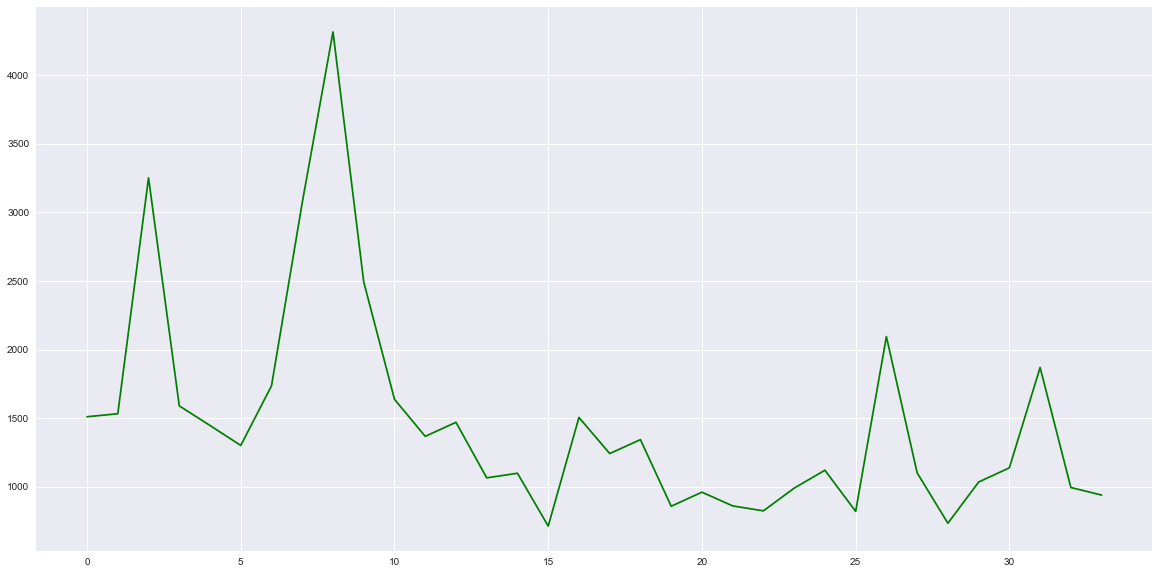

In [153]:
#let try to drop this instance
outlier_df=outlier_df[outlier_df['item_price']<59000]
df=outlier_df.groupby(['date_block_num'])['item_price'].mean()
plt.plot(df.index,df.values,c='g')
plt.show()

#### now it's obvious that the instance with item_price=59200 is an outlier	

### from what we discover above each item_id could have many outliers due to error in item_price

In [160]:
grouped_df = sales.groupby('item_id').agg({'item_price':['min','max','mean','std']})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
grouped_df = grouped_df.reset_index()

In [161]:
grouped_df.head()

,item_id,item_price_min,item_price_max,item_price_mean,item_price_std
0,0,58.0,58.0,58.0,NaN
1,1,4490.0,4490.0,4490.0,0.000000
2,2,58.0,58.0,58.0,0.000000
3,3,58.0,100.0,79.0,29.698485
4,4,58.0,58.0,58.0,NaN


In [162]:
grouped_df.describe()

,item_id,item_price_min,item_price_max,item_price_mean,item_price_std
count,21807.000000,21807.000000,21807.000000,21807.000000,19436.000000
mean,11098.699271,636.704503,930.557752,823.889706,93.443535
std,6397.059362,2663.201489,2937.920391,2784.195525,208.203280
min,0.000000,-1.000000,5.000000,4.914940,0.000000
25%,5551.500000,98.000000,199.000000,186.541323,14.616716
50%,11105.000000,208.000000,399.000000,322.363636,33.965593
75%,16647.500000,599.000000,999.000000,850.000000,93.517263
max,22169.000000,307980.000000,307980.000000,307980.000000,5813.875386


C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Hamza SBAAI\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


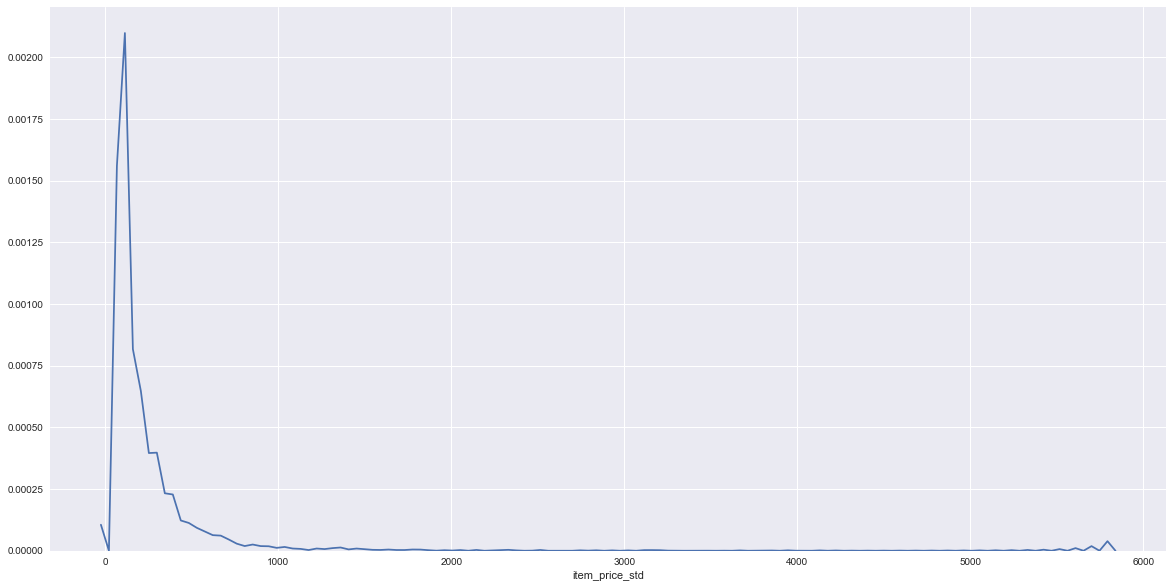

In [169]:
sns.distplot(grouped_df.item_price_std,hist=False)
plt.show()

In [180]:
grouped_df[grouped_df["item_price_std"]>2500].shape

(22, 5)

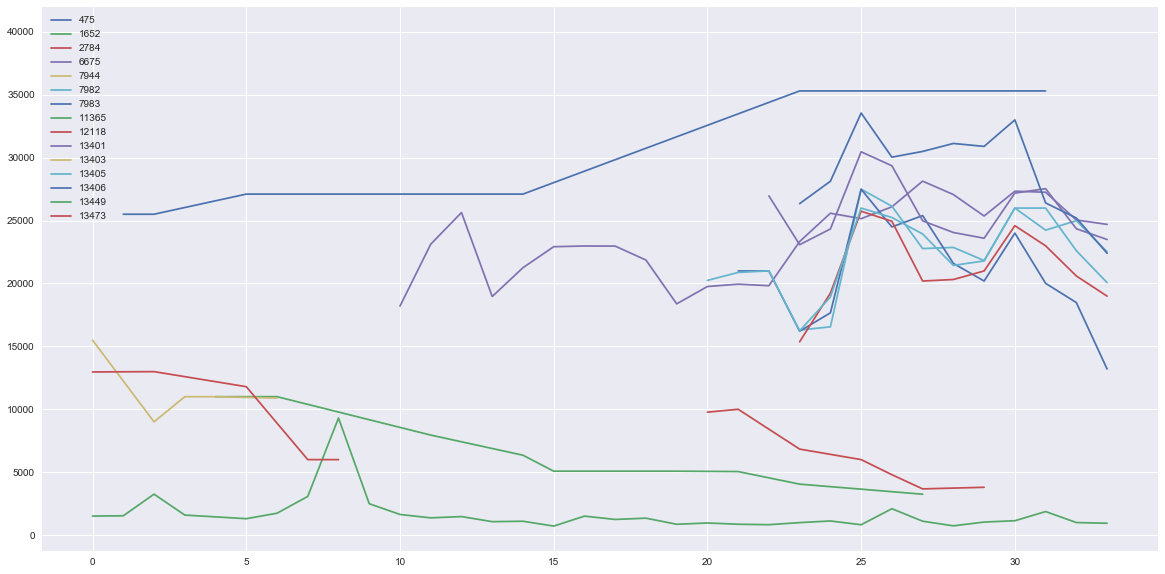

In [181]:
for outlier_id in grouped_df[grouped_df["item_price_std"]>2500].item_id.unique():
    number=len(sales[sales['item_id']==outlier_id])
    if number >=5:    
        outlier_df=sales[sales['item_id']==outlier_id]
        df=outlier_df.groupby(['date_block_num'])['item_price'].mean()
        plt.plot(df.index,df.values,label=outlier_id)
        plt.legend(loc='upper left')
plt.show()

In [184]:
grouped_df=grouped_df[grouped_df["item_price_std"]>2500]

In [358]:
sales.shape

(2935848, 6)

In [186]:
outlier_df=sales[sales['item_id'].isin(grouped_df['item_id'])]
outlier_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000
mean,19.149323,31.092922,7952.242809,20965.337830,1.903553
std,5.932551,16.550056,2560.088771,5368.949482,4.199073
min,0.000000,2.000000,475.000000,124.000000,-3.000000
25%,14.000000,18.000000,6675.000000,18191.000000,1.000000
50%,19.000000,29.000000,6675.000000,20990.000000,1.000000
75%,23.000000,45.000000,7982.000000,23491.000000,2.000000
max,33.000000,59.000000,20666.000000,59200.000000,103.000000


### drop those instance with huge price

In [188]:
to_drop=outlier_df.groupby("item_id")['item_price'].max()
to_drop

item_id
475      35300.0
476      30600.0
1652     10999.0
2410     36990.0
2784      9999.0
3142     30705.0
4857     16132.0
6675     28990.0
7944     15490.0
7982     30990.0
7983     27692.0
11365    59200.0
12118    25990.0
13401    33490.0
13403    42990.0
13405    27192.0
13406    35490.0
13449    32990.0
13473    13990.0
13477    13990.0
14170    27900.0
20666     9999.0
Name: item_price, dtype: float64

In [189]:
to_drop.shape

(22,)

In [193]:
sales['item_id'].isin(to_drop.index)

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13         False
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
23         False
24         False
25         False
26         False
27         False
28         False
29         False
30         False
31         False
32         False
33         False
34         False
35         False
36         False
37         False
38         False
39         False
40         False
41         False
42         False
43         False
44         False
45         False
46         False
47         False
48         False
49         False
50         False
51         False
52         False
53         False
54         False
55         False
56         False
57         False
58         Fal

In [194]:
sales=sales[~((sales['item_id'].isin(to_drop.index)) & (sales['item_price'].isin(to_drop)))]

In [196]:
sales.shape

(2935695, 6)

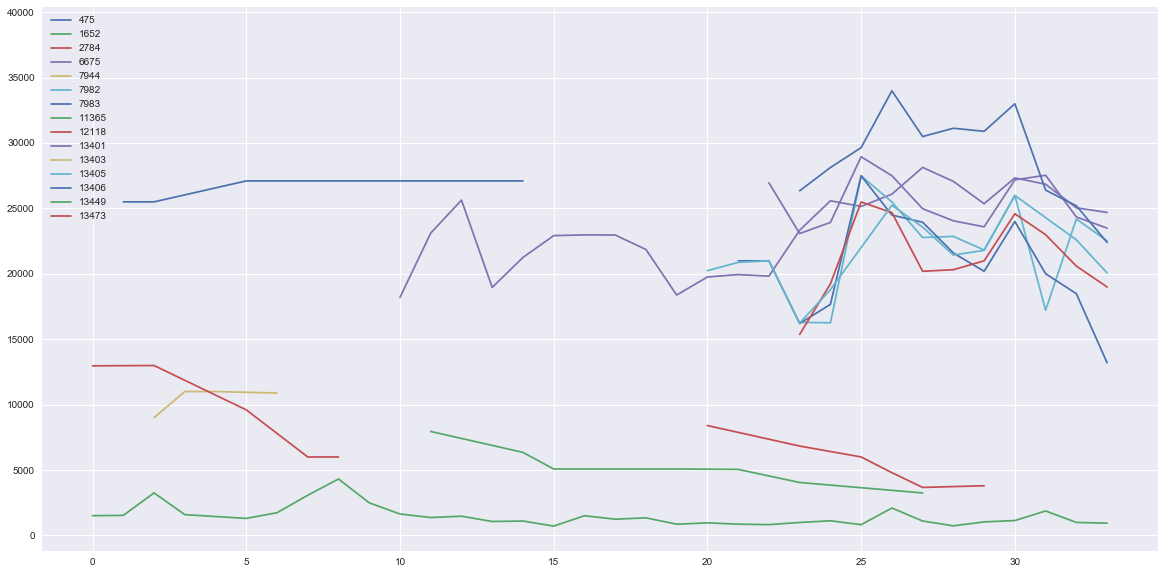

In [197]:
for outlier_id in grouped_df[grouped_df["item_price_std"]>2500].item_id.unique():
    number=len(sales[sales['item_id']==outlier_id])
    if number >=5:    
        outlier_df=sales[sales['item_id']==outlier_id]
        df=outlier_df.groupby(['date_block_num'])['item_price'].mean()
        plt.plot(df.index,df.values,label=outlier_id)
        plt.legend(loc='upper left')
plt.show()